In [11]:
import torch
from torch import nn

m = nn.Conv2d(256, 128, kernel_size=3, padding=1, groups=1, stride=1)
input = torch.randn(1, 256, 64, 64)
output = m(input)
print(output.shape)

torch.Size([1, 128, 64, 64])


In [3]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import AntiAliasInterpolation2d

m = AntiAliasInterpolation2d(3, 0.25)
input = torch.randn(1, 3, 256, 256)
output = m(input)
print(output.shape)

[Errno 2] No such file or directory: 'my_framework_1/content_encoder/modules'
/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 3, 64, 64])


In [4]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import Hourglass

m = Hourglass(32, in_features=3, max_features=1024, num_blocks=5)
input = torch.randn(1, 3, 64, 64)
output = m(input)
print(output.shape)

[Errno 2] No such file or directory: 'my_framework_1/content_encoder/modules'
/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 35, 64, 64])


In [1]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import OcclusionAwareGenerator

dense_motion_params = {
    "block_expansion":64,
    "num_blocks": 5,
    "max_features": 1024,
    # "num_kp": 10,
    # "num_channels": 3,
    # "estimate_occlusion_map": True,
    "scale_factor": 0.25
}
#(64,5,1024,10,3,True,0.25,0.01)

m = OcclusionAwareGenerator(3, 10, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, 
                 dense_motion_params=dense_motion_params, estimate_jacobian=True)
source_image = torch.randn(1, 3, 256, 256)
kp_driving = {
    "heatmap": torch.randn(1, 10, 58, 58),
    "jacobian": torch.randn(1, 10, 2, 2),
    "value": torch.randn(1, 10, 2)
}
kp_source = {
    "heatmap": torch.randn(1, 10, 58, 58),
    "jacobian": torch.randn(1, 10, 2, 2),
    "value": torch.randn(1, 10, 2)
}
output = m(source_image, kp_driving, kp_source)
print(output["mask"].shape)
print(output["sparse_deformed"].shape)
print(output["occlusion_map"].shape)
print(output["deformed"].shape)
print(output["prediction"].shape)

/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 11, 64, 64])
torch.Size([1, 11, 3, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


/root/miniconda3/envs/talkinghead/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/root/miniconda3/envs/talkinghead/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [1]:
%cd ~/TalkingHead/my_framework_1/content_encoder/modules

import torch
from net_module import KPDetector, KPDetector_a, AT_net2, Emotion_k, OcclusionAwareGenerator

kp_detector_params = {
    "temperature": 0.1,
    "block_expansion": 32,
    "max_features": 1024,
    "scale_factor": 0.25,
    "num_blocks": 5
}

common_params = {
    "num_kp": 10,
    "num_channels": 3,
    "estimate_jacobian": True
}

audio_params = {
    "num_kp": 10,
    "num_channels" : 3,
    "num_channels_a" : 3,
    "estimate_jacobian": True
}

dense_motion_params = {
    "block_expansion":64,
    "num_blocks": 5,
    "max_features": 1024,
    "scale_factor": 0.25
}

kp_detector = KPDetector(**kp_detector_params,**common_params)
kp_detector_a = KPDetector_a(**kp_detector_params,**audio_params)
audio_feature = AT_net2()
emo_detector = Emotion_k(block_expansion=32, num_channels=3, max_features=1024,
                 num_blocks=5, scale_factor=0.25, num_classes=8)
generator = OcclusionAwareGenerator(3, 10, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, 
                 dense_motion_params=dense_motion_params, estimate_jacobian=True)
if torch.cuda.is_available():
    kp_detector.to("cuda:0")
    kp_detector_a.to("cuda:0")
    audio_feature.to("cuda:0")
    emo_detector.to("cuda:0")
    generator.to("cuda:0")



/root/TalkingHead/my_framework_1/content_encoder/modules


In [2]:
checkpoint = torch.load('/root/TalkingHead/log/124_52000.pth.tar')
audio_checkpoint = torch.load('/root/TalkingHead/log/1-6000.pth.tar')
emo_checkpoint = torch.load('/root/TalkingHead/log/5-3000.pth.tar')

generator.load_state_dict(checkpoint['generator'])
kp_detector.load_state_dict(checkpoint['kp_detector'])
audio_feature.load_state_dict(audio_checkpoint['audio_feature'])
kp_detector_a.load_state_dict(audio_checkpoint['kp_detector_a'])
emo_detector.load_state_dict(emo_checkpoint['emo_detector'])

generator.eval()
kp_detector.eval()
audio_feature.eval()
kp_detector_a.eval()
emo_detector.eval()

Emotion_k(
  (predictor): Hourglass(
    (encoder): Encoder(
      (down_blocks): ModuleList(
        (0): DownBlock2d(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (1): DownBlock2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (2): DownBlock2d(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (3): DownBlock2d(


In [28]:
source_image_file = '/root/TalkingHead/test/image/7.png'
driving_video_file = '/root/TalkingHead/test/video/disgusted.mp4'
pose_file = '/root/TalkingHead/test/pose/7.npy'
# pose_given = '/root/TalkingHead/test/pose_long/0zn70Ak8lRc_Daniel_Auteuil_0zn70Ak8lRc_0002.npy'
in_file = '/root/TalkingHead/test/audio/sample1.mov'

In [29]:
%cd /root/TalkingHead/my_framework_1/content_encoder/modules

import dlib
import numpy as np
import cv2
from skimage import transform as tf
import imageio
from util_module import AllAugmentationTransform

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/root/mlxtend_data/shape_predictor_68_face_landmarks.dat')

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def get_aligned_image(driving_video, emotion):
    aligned_array = []

    video_array = np.array(driving_video)
    source_image=video_array[0]
   # aligned_array.append(source_image)
    source_image = np.array(source_image * 255, dtype=np.uint8)
    gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)  #detect human face
    for (i, rect) in enumerate(rects):
        template = predictor(gray, rect) #detect 68 points
        template = shape_to_np(template)

    if emotion == 'surprised' or emotion == 'fear':
        template = template-[0,10]
    for i in range(len(video_array)):
        image=np.array(video_array[i] * 255, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 1)  #detect human face
        for (j, rect) in enumerate(rects):
            shape = predictor(gray, rect) #detect 68 points
            shape = shape_to_np(shape)

        pts2 = np.float32(template[:35,:])
        pts1 = np.float32(shape[:35,:]) #eye and nose

    #    pts2 = np.float32(np.concatenate((template[:16,:],template[27:36,:]),axis = 0))
    #    pts1 = np.float32(np.concatenate((shape[:16,:],shape[27:36,:]),axis = 0)) #eye and nose
        # pts1 = np.float32(landmark[17:35,:])
        tform = tf.SimilarityTransform()
        tform.estimate( pts2, pts1) #Set the transformation matrix with the explicit parameters.
        dst = tf.warp(image, tform, output_shape=(256, 256))

        dst = np.array(dst, dtype=np.float32)
        aligned_array.append(dst)

    return aligned_array

augmentation_params = {
    'flip_param': {
        'horizontal_flip': False,
        'time_flip': False
    },
    'jitter_param': {
        'brightness': 0.1,
        'contrast': 0.1,
        'saturation': 0.1,
        'hue': 0.1
    },
}
def get_transformed_image(driving_video):
    video_array = np.array(driving_video)
    transformations = AllAugmentationTransform(**augmentation_params)
    transformed_array = transformations(video_array)
    return transformed_array

reader = imageio.get_reader(driving_video_file)
fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

from skimage.transform import resize
from skimage import io, img_as_float32

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
driving_video = get_aligned_image(driving_video, 'disgusted')
transformed_video = get_transformed_image(driving_video)
transformed_video = np.array(transformed_video)
print(transformed_video.shape)

/root/TalkingHead/my_framework_1/content_encoder/modules
(203, 256, 256, 3)


In [30]:
import numpy as np

input_mfcc = []
for i in range(1, 70):
    mfcc_path = f'/root/Datasets/Features/M003/mfccs/disgusted/level_3/00001/{i:05d}.npy'
    mfcc_data = np.load(mfcc_path)
    mfcc_data = torch.FloatTensor(mfcc_data).to("cuda:0")
    input_mfcc.append(mfcc_data)
input_mfcc = torch.stack(input_mfcc, dim=0)
input_mfcc = input_mfcc.unsqueeze(0)
print(input_mfcc.shape)

torch.Size([1, 69, 28, 12])


In [31]:
import numpy as np
from torch.autograd import Variable
all_pose = np.load(pose_file)
pose = all_pose[:,:6]
if len(pose) == 1:
    pose = np.repeat(pose,input_mfcc.shape[1],0)
pose = Variable(torch.FloatTensor(pose.astype(float)) ).to("cuda:0")
pose = pose.unsqueeze(0)
print(pose.shape)

torch.Size([1, 69, 6])


In [32]:
from skimage.transform import resize
from skimage import io, img_as_float32
from torch.autograd import Variable

source_image = img_as_float32(io.imread(source_image_file))
source_image = resize(source_image, (256, 256))[..., :3]
print(source_image.shape)
example_image = np.array(source_image, dtype='float32').transpose((2, 0, 1))
example_image = Variable(torch.FloatTensor(example_image.astype(float)) ).to("cuda:0")
example_image = torch.unsqueeze(example_image,0)
print(example_image.shape)

(256, 256, 3)
torch.Size([1, 3, 256, 256])


In [33]:
deco_out = audio_feature(example_image,input_mfcc,pose,'cnn',1.6)
print(deco_out.shape)

torch.Size([1, 69, 35, 64, 64])


In [45]:
%cd /root/TalkingHead/my_framework_1/content_encoder/modules

import os
from skimage import img_as_ubyte
from util_module import make_animation_smooth

predictions, _ = make_animation_smooth(source_image, driving_video, transformed_video, deco_out, 0, generator, kp_detector, kp_detector_a, emo_detector, False, relative=False, adapt_movement_scale=False, cpu=False)
imageio.mimsave(os.path.join('/root/TalkingHead/','neutral.mp4'), [img_as_ubyte(frame) for frame in predictions], fps=15)

/root/TalkingHead/my_framework_1/content_encoder/modules


100%|██████████| 69/69 [00:02<00:00, 30.00it/s]


In [35]:
import numpy as np

driving_images = []
for i in range(1, 18):
    image_path = f'/root/Datasets/Features/M003/images/disgusted/level_1/00001/{i:05d}.jpg'
    image = img_as_float32(io.imread(image_path))
    image = resize(image, (256, 256))[..., :3]
    image = np.array(image, dtype='float32').transpose((2, 0, 1))
    image = Variable(torch.FloatTensor(image.astype(float)) ).to("cuda:0")
    driving_images.append(image)
    
driving_images = torch.stack(driving_images, dim=0)
driving_images = driving_images.unsqueeze(0)
print(driving_images.shape)

torch.Size([1, 17, 3, 256, 256])


In [36]:
kp_source = kp_detector(example_image)
print('kp_source')
print(kp_source["jacobian"].shape)
print(kp_source["heatmap"].shape)
print(kp_source["value"].shape)
kp_driving = []
kp_driving_a = [] 
for i in range(17):
    kp_driving.append(kp_detector(driving_images[:,i]))
    kp_driving_a.append(kp_detector_a(deco_out[:,i]))
print('kp_driving')
print(kp_driving[0]["jacobian"].shape)
print(kp_driving[0]["heatmap"].shape)
print(kp_driving[0]["value"].shape)
print('kp_driving_a')
print(kp_driving_a[0]["jacobian"].shape)
print(kp_driving_a[0]["heatmap"].shape)
print(kp_driving_a[0]["value"].shape)


kp_source
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])
kp_driving
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])
kp_driving_a
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])


In [39]:
output = generator(example_image, kp_source, kp_driving_a[10])
print(output["mask"].shape)
print(output["sparse_deformed"].shape)
print(output["occlusion_map"].shape)
print(output["deformed"].shape)
print(output["prediction"].shape)

torch.Size([1, 11, 64, 64])
torch.Size([1, 11, 3, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


(256, 256, 3)


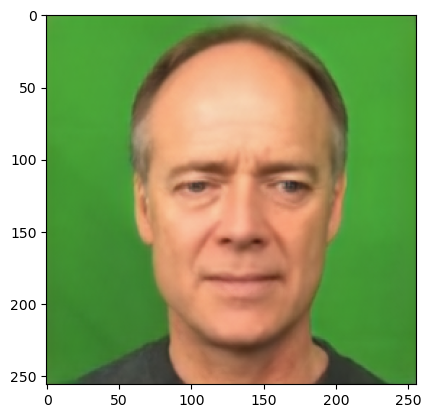

In [40]:
import matplotlib.pyplot as plt

img = output["prediction"][0]
img = img.cpu().detach().numpy()
img = img.transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

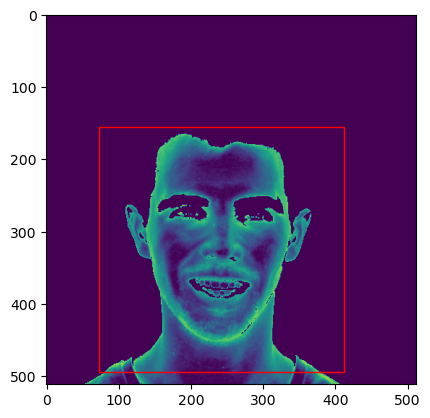

In [66]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

file_path = '/root/Datasets/Features/M003/images/happy/level_1/00001/00010.jpg'
image = cv2.imread(file_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
image_copy = image.copy()
image_copy = image_copy[:,:,2] * thresh

lm_path = file_path.replace('images', 'landmarks74')
lm_path = lm_path.replace('jpg', 'json')
with open(lm_path, 'rt') as f:
    lm_data = json.load(f)
    lm_bb = lm_data['bb']
fig, ax = plt.subplots()
ax.imshow(image_copy)
rect = patches.Rectangle((lm_bb[0],lm_bb[1]), lm_bb[2]-lm_bb[0], lm_bb[3] - lm_bb[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

file_path = '/root/Datasets/Features/M003/images/happy/level_1/00001/00010.jpg'
image = cv2.imread(file_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
image_copy = image.copy()
image_copy = image_copy[:,:,2] * thresh

lm_path = file_path.replace('images', 'landmarks74')
lm_path = lm_path.replace('jpg', 'json')
with open(lm_path, 'rt') as f:
    lm_data = json.load(f)
    lm_bb = lm_data['bb']
fig, ax = plt.subplots()
ax.imshow(image_copy)
rect = patches.Rectangle((lm_bb[0],lm_bb[1]), lm_bb[2]-lm_bb[0], lm_bb[3] - lm_bb[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [1]:
%cd /root/TalkingHead/my_framework_1/content_encoder

import torch
from modules.net_module import UNet

#(type, input, output, kernel, padding, stride)
encoder_params = [
    ('same', 1, 64),    #(256,256,64)
    ('down', 64, 64),   #(128,128,64)
    ('down', 64, 128),  #(64,64,128)
    ('down', 128, 256), #(32,32,256)
    ('down', 256, 512), #(16,16,512)
    ('down', 512, 512), #(8,8,512)
    ('down', 512, 512), #(4,4,512)
    ('down', 512, 512), #(2,2,512)
]
decoder_params = [
    ('up', 512, 512),   #(4,4,512)
    ('up', 512*2, 512),   #(8,8,512)
    ('up', 512*2, 512),   #(16,16,512)
    ('up', 512*2, 256),   #(32,32,256)
    ('up', 256*2, 128),   #(64,64,128)
    ('up', 128*2, 64),    #(128,128,64)
    ('up', 64*2, 64),     #(256,256,64)
    ('same', 64*2, 1),    #(256,256,1)
]

m = UNet(encoder_params=encoder_params, decoder_params=decoder_params)
source_image = torch.randn(1, 1, 256, 256)
output = m(source_image)
print(output.shape)


/root/TalkingHead/my_framework_1/content_encoder
torch.Size([1, 1, 256, 256])


In [1]:
import warnings
from scipy.optimize import curve_fit

def draw_edge(im, x, y, bw=1, color=(255, 255, 255), draw_end_points=False):
    r"""Set colors given a list of x and y coordinates for the edge.

    Args:
        im (HxWxC numpy array): Canvas to draw.
        x (1D numpy array): x coordinates of the edge.
        y (1D numpy array): y coordinates of the edge.
        bw (int): Width of the stroke.
        color (list or tuple of int): Color to draw.
        draw_end_points (bool): Whether to draw end points of the edge.
    """
    if x is not None and x.size:
        h, w = im.shape[0], im.shape[1]
        # Draw edge.
        for i in range(-bw, bw):
            for j in range(-bw, bw):
                yy = np.maximum(0, np.minimum(h - 1, y + i))
                xx = np.maximum(0, np.minimum(w - 1, x + j))
                set_color(im, yy, xx, color)

        # Draw endpoints.
        if draw_end_points:
            for i in range(-bw * 2, bw * 2):
                for j in range(-bw * 2, bw * 2):
                    if (i ** 2) + (j ** 2) < (4 * bw ** 2):
                        yy = np.maximum(0, np.minimum(h - 1, np.array(
                            [y[0], y[-1]]) + i))
                        xx = np.maximum(0, np.minimum(w - 1, np.array(
                            [x[0], x[-1]]) + j))
                        set_color(im, yy, xx, color)


def set_color(im, yy, xx, color):
    r"""Set pixels of the image to the given color.

    Args:
        im (HxWxC numpy array): Canvas to draw.
        xx (1D numpy array): x coordinates of the pixels.
        yy (1D numpy array): y coordinates of the pixels.
        color (list or tuple of int): Color to draw.
    """
    if type(color) != list and type(color) != tuple:
        color = [color] * 3
    if len(im.shape) == 3 and im.shape[2] == 3:
        if (im[yy, xx] == 0).all():
            im[yy, xx, 0], im[yy, xx, 1], im[yy, xx, 2] = \
                color[0], color[1], color[2]
        else:
            for c in range(3):
                im[yy, xx, c] = ((im[yy, xx, c].astype(float)
                                  + color[c]) / 2).astype(np.uint8)
    else:
        im[yy, xx] = color[0]


def interp_points(x, y):
    r"""Given the start and end points, interpolate to get a curve/line.

    Args:
        x (1D array): x coordinates of the points to interpolate.
        y (1D array): y coordinates of the points to interpolate.

    Returns:
        (dict):
          - curve_x (1D array): x coordinates of the interpolated points.
          - curve_y (1D array): y coordinates of the interpolated points.
    """
    if abs(x[:-1] - x[1:]).max() < abs(y[:-1] - y[1:]).max():
        curve_y, curve_x = interp_points(y, x)
        if curve_y is None:
            return None, None
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                if len(x) < 3:
                    popt, _ = curve_fit(linear, x, y)
                else:
                    popt, _ = curve_fit(func, x, y)
                    if abs(popt[0]) > 1:
                        return None, None
            except Exception:
                return None, None
        if x[0] > x[-1]:
            x = list(reversed(x))
            y = list(reversed(y))
        curve_x = np.linspace(x[0], x[-1], int(np.round(x[-1]-x[0])))
        if len(x) < 3:
            curve_y = linear(curve_x, *popt)
        else:
            curve_y = func(curve_x, *popt)
    return curve_x.astype(int), curve_y.astype(int)


def func(x, a, b, c):
    r"""Quadratic fitting function."""
    return a * x**2 + b * x + c


def linear(x, a, b):
    r"""Linear fitting function."""
    return a * x + b

In [44]:
from my_framework.modules.face_visual_module import connect_face_keypoints
import matplotlib.pyplot as plt
import numpy as np
from my_framework.modules.util_module import create_video
import json

datas = []
for index in range(12,37):
    with open(f'/root/Datasets/Features/M003/landmarks74/sad/level_1/00024/{index:05d}.json', 'rt') as f:
        data = json.load(f)
    lm_data = data['lm68'] * np.asarray(256/(data['bb'][2] - data['bb'][0]))
    datas.append([lm_data])

lm_data_list = np.vstack(datas).astype(np.float32)
lm_data_list = lm_data_list.reshape(*lm_data_list.shape[0:-2], -1)
keypoints = lm_data_list.reshape(-1,68,2)

outputs = connect_face_keypoints(256,256,keypoints,add_upper_face=True,add_dist_map=False)
create_video(outputs,f'test.mp4')

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [10]:
from my_framework.modules.net_module import *

num_channels=3
block_expansion=64
num_blocks=4
max_features=512
sn=False
use_kp=False
num_kp=10
kp_variance=0.01

down_blocks = []
for i in range(num_blocks):
    down_blocks.append(
        DownBlock2d(num_channels + num_kp * use_kp if i == 0 else min(max_features, block_expansion * (2 ** i)),
                    min(max_features, block_expansion * (2 ** (i + 1))),
                    kernel_size=4,padding=0,stride=1))

down_blocks = nn.ModuleList(down_blocks)
conv = nn.Conv2d(down_blocks[-1].conv.out_channels, out_channels=1, kernel_size=1)

In [14]:
import torch
feature_maps = []
out = torch.rand(128,3,64,64)

for down_block in down_blocks:
    feature_maps.append(down_block(out))
    out = feature_maps[-1]
    print(out.shape)
prediction_map = conv(out)


torch.Size([128, 128, 30, 30])
torch.Size([128, 256, 13, 13])
torch.Size([128, 512, 5, 5])
torch.Size([128, 512, 1, 1])


In [3]:
import numpy as np
y_pred = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y_test = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

np.count_nonzero(y_pred == y_test) / len(y_test)

1.0

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Số phân lớp: 4
K = 4
# Tạo bộ dữ  liệu gồm 4 điểm
# S1, S2, S3, S4 là tâm của 4 lớp
S1= np.array([[10,-2]])
S2= np.array([[2,8]])
S3= np.array([[12,8]])
S4= np.array([[-2,0]])

# 50 samples mỗi lớp
n_sample = 50
# Phát sinh các điểm với nhiễu ngẫu nhiên xung quanh 4 tâm
pts1 = S1 + np.random.normal(0, 1.5, size=(n_sample,2))
pts2 = S2 + np.random.normal(0, 1.5, size=(n_sample,2))
pts3 = S3 + np.random.normal(0, 1.5, size=(n_sample,2))
pts4 = S4 + np.random.normal(0, 1.5, size=(n_sample,2))

# Nối tất cả các mẫu thành một khối dữ liệu X (input feature) và Y (nhãn)
X_train = np.concatenate((pts1, pts2, pts3, pts4))
# Concatenate data labels to a single input variable Y
Y_train = np.concatenate(([0]*n_sample, [1]*n_sample, [2]*n_sample, [3]*n_sample))

# Chuyển Y từ dạng nhãn sang one-hot vector
Y_train = Y_train.astype(int)
Y_oh = np.zeros((Y_train.size, Y_train.max()+1 ))
Y_oh[np.arange(Y_train.size), Y_train] = 1

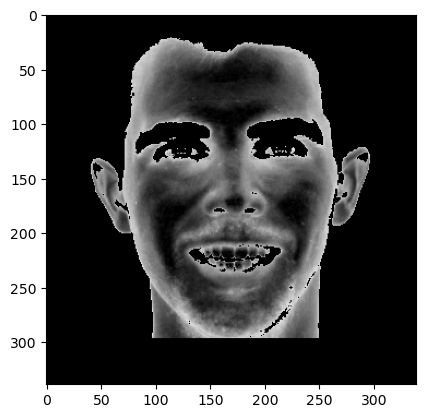

In [207]:
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
import cv2
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks
from my_framework.modules.face_visual_module import connect_face_keypoints

raw_img = cv2.imread('/root/Datasets/Features/M003/images/happy/level_1/00001/00001.jpg')

img = raw_img
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.8) as face_detection:
    # results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    results = face_detection.process(img)
    if results.detections:
        index_detection = 0
        max_score_detection = results.detections[0].score[0]
        for index in range(1, len(results.detections)):
            if results.detections[index].score[0] > max_score_detection:
                index_detection = index
                max_score_detection = results.detections[index].score[0]
        
        detection = results.detections[index_detection]
        bb = detection.location_data.relative_bounding_box
        xmin = int(bb.xmin*img.shape[1]) - 50
        ymin = int(bb.ymin*img.shape[0]) - 50
        width, height = int(bb.width*img.shape[1]), int(bb.height*img.shape[0])
        xmax = int(bb.xmin*img.shape[1]) + width + 50
        ymax = int(bb.ymin*img.shape[0]) + height + 50
        face = img[ymin:ymax, xmin:xmax].copy()
        
        landmarks = extract_face_landmarks(face)
        
maxface = np.max(landmarks[:,1], axis=0)


img = face
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
img = img[:,:,2] * thresh
img = 255 - img
img[maxface:,:] = 255

plt.imshow(img, cmap=plt.cm.binary)

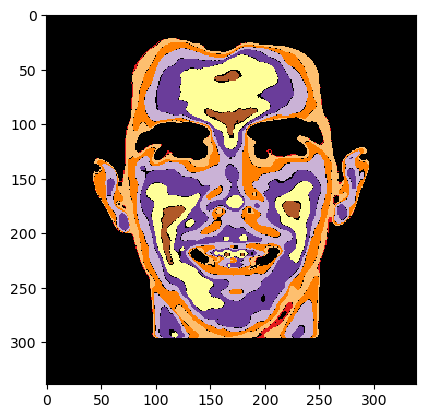

In [208]:
import numpy as np

result = np.zeros_like(img)
temp = img.copy()
temp[temp==255]=0
temp = cv2.medianBlur(temp,7)

segment = 255//10
for index, i in enumerate(range(0,255,segment)):
    mask = np.bitwise_and((i < temp), (temp < i + segment))
    result[mask == True] = index + 1

cmap = plt.cm.get_cmap("Paired").copy()
cmap.set_under('black')

plt.imshow(result, cmap=cmap, vmin=0.001, interpolation='nearest')

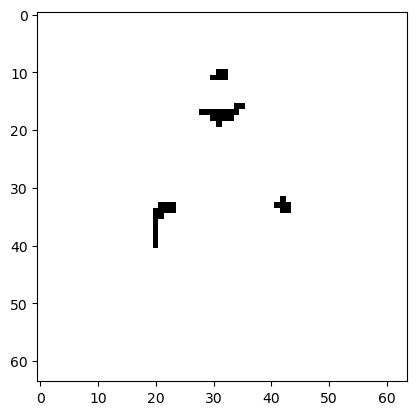

In [209]:
result1 = result.copy()

result1[np.bitwise_and(result1 != 11 , result1 != 11)] = 0
result1[np.bitwise_or(result1 == 11 , result1 == 11)] = 1
# result1 = 1 - result1
result1 = cv2.medianBlur(result1,7)
plt.imshow(result1, cmap=plt.cm.binary, interpolation='nearest')
result1 = cv2.resize(result1, (64,64))
plt.imshow(result1, cmap=plt.cm.binary, interpolation='nearest')

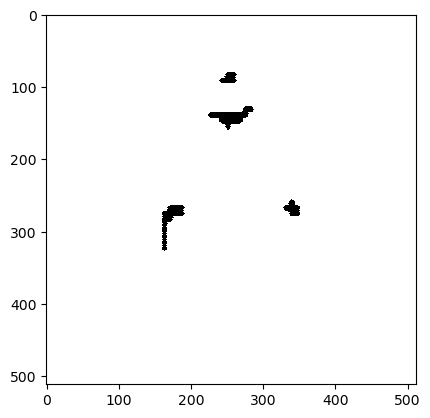

In [210]:
result2 = cv2.resize(result1, (512,512))
plt.imshow(result2, cmap=plt.cm.binary, interpolation='nearest')

/tmp/ipykernel_636904/1562976860.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/root/Datasets/Features/M003/faces/angry/level_3/00001/00001.jpg')


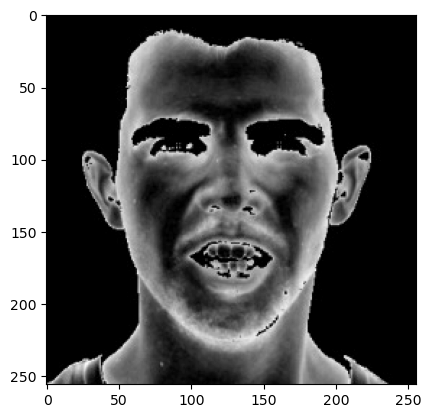

In [56]:
import json
import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np

with open('/root/Datasets/Features/M003/landmarks74/angry/level_1/00001/00001.json', 'r') as f:
    data = json.load(f)
lm = data['lm68']
bb = data['bb']
newlm = (lm * np.array((256,256)))//np.array((bb[2] - bb[0], bb[3] - bb[1]))

img = imageio.imread('/root/Datasets/Features/M003/faces/angry/level_3/00001/00001.jpg')
plt.imshow(255-img, cmap=plt.cm.binary)

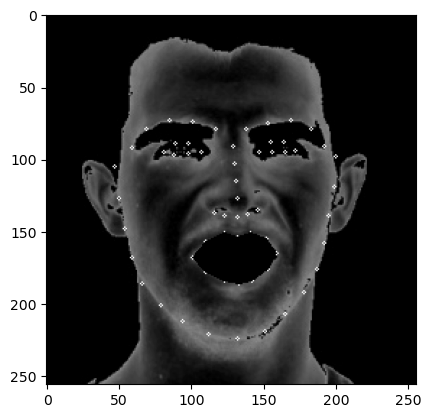

In [291]:
draw_img = img.copy()
for i in range(0,len(newlm[:,0])):
    cv2.circle(draw_img, (int(newlm[i,0]), int(newlm[i,1])), 1, (255,255,255), 1)

pts = np.array([np.column_stack((newlm[48:60,0], newlm[48:60,1]))], np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(draw_img, [pts],(0,0,0))

plt.imshow(255-draw_img, cmap=plt.cm.binary)

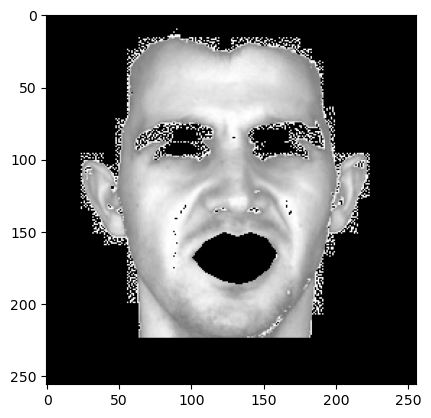

In [23]:
result = np.zeros_like(img)
seg_img = img.copy()
pts = np.array([np.column_stack((newlm[48:60,0], newlm[48:60,1]))], np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(seg_img, [pts],(0,0,0))
pts = np.array([np.column_stack((newlm[36:42,0], newlm[36:42,1]))], np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(seg_img, [pts],(0,0,0))
pts = np.array([np.column_stack((newlm[42:48,0], newlm[42:48,1]))], np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(seg_img, [pts],(0,0,0))

minface = np.max(newlm[:,1], axis=0)
seg_img[minface:,:] = 0
seg_img = 255-seg_img
seg_img[seg_img==255] = 0

plt.imshow(255-seg_img, cmap=plt.cm.binary)

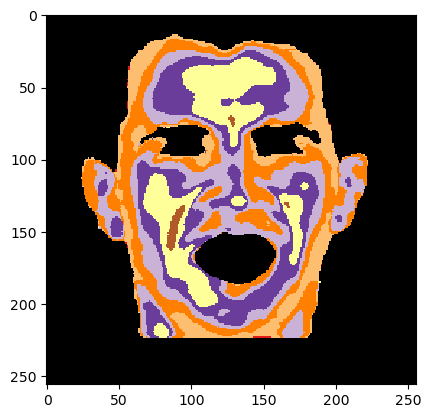

In [24]:
segment = 255//10
for index, i in enumerate(range(0,255,segment)):
    mask = np.bitwise_and((i < seg_img), (seg_img < i + segment))
    result[mask == True] = index + 1

result = cv2.medianBlur(result,7)
cmap = plt.cm.get_cmap("Paired").copy()
cmap.set_under('black')

plt.imshow(result, cmap=cmap, vmin=0.001, interpolation='nearest')

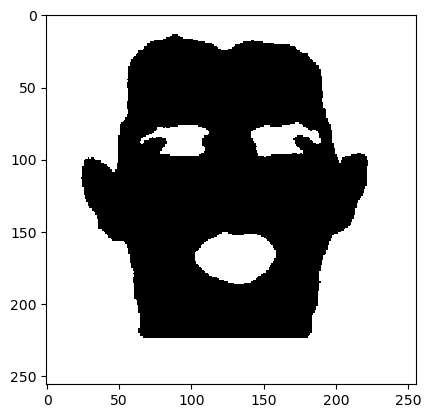

In [39]:
result1 = result.copy()

result1[result1 < 1] = 0
result1[result1 >= 1] = 1
# result1 = cv2.resize(result1, (32,32))
plt.imshow(result1, cmap=plt.cm.binary, interpolation='nearest')

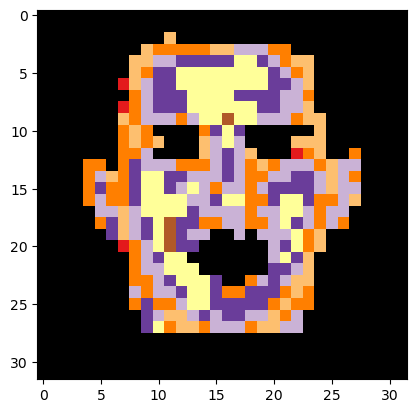

In [66]:
temp = cv2.resize(result, (32,32), interpolation=cv2.INTER_NEAREST)
plt.imshow(temp, cmap=cmap, vmin=0.001, interpolation='nearest')

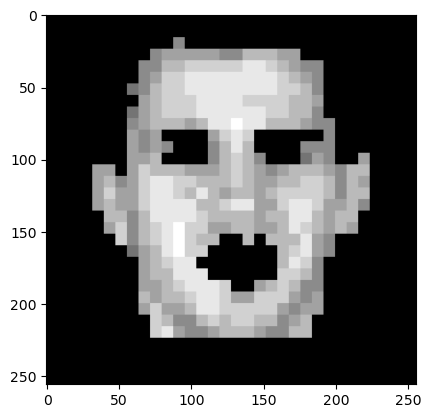

In [67]:
temp1 = cv2.resize(temp, (256,256), interpolation=cv2.INTER_AREA)
plt.imshow(255-temp1, cmap=plt.cm.binary)

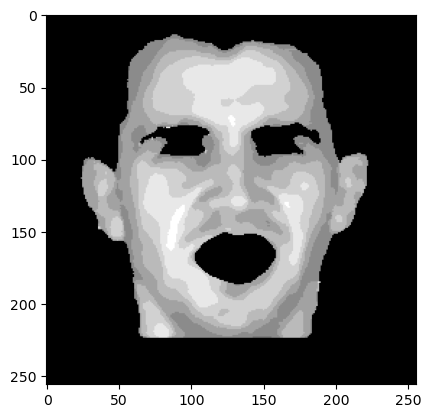

In [62]:
plt.imshow(255-result, cmap=plt.cm.binary)

In [71]:
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
outputs_pred = connect_face_keypoints(256,256,lm_pred)
outputs_gt = connect_face_keypoints(256,256,lm_gt)

# Export to video
outputs = []
for i in range(len(outputs_gt)):
    result_img = np.zeros((256, 256*2, 1))
    result_img[:,:256,:] = outputs_gt[i] * 255
    result_img[:,256:,:] = outputs_pred[i] * 255
    outputs.append(result_img)

create_video(outputs,f'/root/TalkingHeadProject/my_framework/result_A2LM_Conv/prediction.mp4', fps=10)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [1]:
import numpy as np
import tensorflow as tf

def mld(y_true, y_pred):
    return tf.norm(y_true - y_pred, ord='euclidean')

lm_pred = np.load(f'/root/TalkingHeadProject/my_framework/result_A2LM_Conv/lm_pred.npy')
lm_gt = np.load(f'/root/TalkingHeadProject/my_framework/result_A2LM_Conv/lm_gt.npy')

In [4]:
mld(lm_gt, lm_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=101.39713>

In [5]:
import numpy as np

from my_framework.modules.face_visual_module import connect_face_keypoints
from my_framework.modules.util_module import *

lm_pred = np.load(f'/root/TalkingHeadProject/my_framework/result_A2LM_LMAudioPrev/lm_pred.npy')
lm_gt = np.load(f'/root/TalkingHeadProject/my_framework/result_A2LM_LMAudioPrev/lm_gt.npy')

def compute_mld(lm1, lm2):
    distances = np.sqrt(np.sum((lm1-lm2)**2, axis=1))
    # normalize_distance = np.sqrt(np.sum((lm1[0] - lm1[16])**2))
    normalize_distance = 1
    normalized_distances = distances / normalize_distance
    mld = np.mean(normalized_distances)
    return mld

total_mean = 0
for i in range(lm_gt.shape[0]):
    total_mean = total_mean + np.mean(compute_mld(lm_gt[i], lm_pred[i]))
print(total_mean / lm_gt.shape[0])

2.6439875602722167


In [6]:
from my_framework.evaluation.evaluation_landmark import *

lm_pred_exp = lm_pred[np.newaxis, ...]
lm_gt_exp = lm_gt[np.newaxis, ...]

print(lm_gt_exp.shape)
# gt_norm = lm_gt_exp[:, :, 0] - lm_gt_exp[:, :, 16]
# face_width_distance = np.sqrt(np.sum(gt_norm**2, axis=2))
face_width_distance = 1

lmd = calculate_LMD(lm_pred_exp, lm_gt_exp, norm_distance=face_width_distance)
print(f'LMD: {lmd}')

(1, 25, 68, 2)
LMD: 2.6439876556396484


In [4]:
import torch

# Tạo torch array audio với kích thước 10x25x130
audio_out = torch.randn(10, 25, 130)

lm_in = torch.zeros((10,25,260))

lm_in[:,0:1,:] = torch.cat((audio_out[:,0:1,:], audio_out[:,0:1,:]), dim=2)
print(lm_in.shape)
for i in range(1, audio_out.size(1)):
    lm_in[:,i:i+1,:] = torch.cat((audio_out[:,i-1:i,:], audio_out[:,i:i+1,:]), dim=2)
print(lm_in.shape)

torch.Size([10, 25, 260])
torch.Size([10, 25, 260])
